In [4]:
from __future__ import print_function

import argparse

import numpy as np
import torch
import torch.utils.data

import make_lsm_signals
from model import RecurrentNetTimeVariable

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
use_cuda = False
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = RecurrentNetTimeVariable(n_in=200, n_hid=500, n_out=1,
                                     use_cuda=use_cuda).to(device)
model.load_state_dict(torch.load('./work/04080342_lsmsignals_netsize_500_stimdur_7_nstim_3_respdur_5_epoch_991.pth', map_location='cpu'))



cpu


In [88]:
def lsm_signals(n_episodes=100, n_in=100, stim_dur=15,
                sig1_stim_dur=20, resp_dur=10, each_episodes=10, kappa=5.0, spon_rate=0.08, n_stim=3):
    phi = np.linspace(0, np.pi, n_in)
    n_loc = 1
    nneuron = n_in * n_loc
    total_dur = n_stim * (stim_dur + resp_dur)
    G = (1.0 / stim_dur) * np.random.choice([1.0], 1)
    G = np.repeat(G, n_in, axis=0).T
    G = np.tile(G, (stim_dur, 1))

    # signal2
    Stims = []
    Stims_ = []
    Ls = []
    Rs = []
    for episode in range(n_episodes):
        episode_stim = []
        for i in range(n_stim):
            S = np.pi * np.random.rand(1)
            S_ = S.copy()
            S = np.repeat(S, n_in, axis=0).T
            S = np.tile(S, (stim_dur, 1))
            Stims.append(S)
            episode_stim.append(S_)

            # Noisy responses
            L = G * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (stim_dur, n_loc)))) - 1.0))  # stim

            Ls.append(L)
            R = np.random.poisson(L)
            Rs.append(R)
        Stims_.append(episode_stim)
        Lr = (spon_rate / resp_dur) * np.ones((resp_dur * n_stim, nneuron))  # resp
        Rr = np.random.poisson(Lr)

        Rs.append(Rr)

    signal2 = np.concatenate(tuple(Rs), axis=0)

    G1 = (3.0 / sig1_stim_dur) * np.random.choice([1.0], 1)
    G1 = np.repeat(G1, n_in, axis=0).T
    G1 = np.tile(G1, (sig1_stim_dur, 1))
    # signal1 & target
    a = np.random.poisson(0.8, n_episodes)
    Rs1 = []
    accum_signal = np.pi * np.random.rand(1)
    target_list = []

    for episode in range(n_episodes):
        target_list.append(np.zeros(stim_dur * n_stim))
        if a[episode] == 2 or episode % each_episodes == 0:
            print(episode)
            accum_signal = np.pi * np.random.rand(1)
            S = np.repeat(accum_signal, n_in, axis=0).T
            S = np.tile(S, (sig1_stim_dur, 1))

            L = G1 * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (sig1_stim_dur, n_loc)))) - 1.0))  # stim
            R = np.random.poisson(L)
            Rs1.append(R)
        else:
            Lr = (spon_rate / resp_dur) * np.ones((sig1_stim_dur, nneuron))  # resp
            R = np.random.poisson(Lr)
            Rs1.append(R)
        L_spont = (spon_rate / resp_dur) * np.ones((total_dur - sig1_stim_dur, nneuron))  # resp
        R = np.random.poisson(L_spont)
        Rs1.append(R)

        for i in range(n_stim):
            target = np.repeat(Stims_[episode][i]+accum_signal, resp_dur, axis=0)
            # target = np.repeat(Stims_[episode][i], resp_dur, axis=0)
            target_list.append(target)

    signal1 = np.concatenate(tuple(Rs1), axis=0)

    target = np.concatenate(tuple(target_list), axis=0)
    target = np.expand_dims(target, 1)

    signal = np.concatenate((signal1, signal2), axis=1)
    return signal, target

In [95]:
signals = []
targets = []
for i in range(1):
    signal, target = lsm_signals(n_episodes=20,
                                                  stim_dur=7,
                                                  sig1_stim_dur=7,
                                                  resp_dur=5,
                                                  each_episodes=7,
                                                  spon_rate=0.01)
    signals.append(signal)
    targets.append(target)

signals = np.array(signals)
targets = np.array(targets)

signals = torch.from_numpy(signals)
targets = torch.from_numpy(targets)

hidden = torch.zeros(1, 500, requires_grad=False)
hidden = hidden.to(device)

signals = signals.float()
targets = targets.float()

signals, targets = signals.to(device), targets.to(device)

hidden_list, output, hidden = model(signals, hidden)


0
7
13
14


/Users/kohei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [96]:
print(hidden_list.shape)

torch.Size([1, 720, 500])


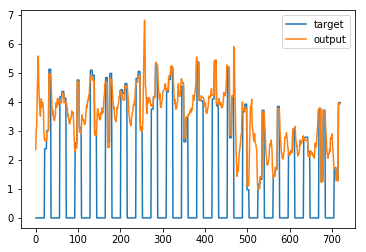

In [97]:
plt.plot(targets[0].data.numpy().T[0], label='target')
plt.plot(output[0].data.numpy().T[0], label='output')
plt.legend()

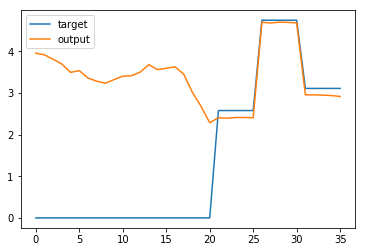

In [127]:
plt.plot(targets[0].data.numpy().T[0][72:108], label='target')
plt.plot(output[0].data.numpy().T[0][72:108], label='output')
plt.legend()
plt.savefig('result/long_short/training_result.png')

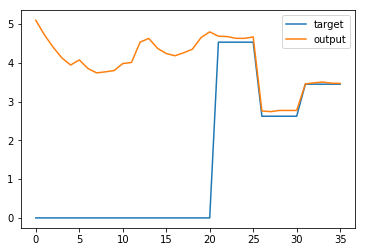

In [99]:
plt.plot(targets[0].data.numpy().T[0][324:360], label='target')
plt.plot(output[0].data.numpy().T[0][324:360], label='output')
plt.legend()

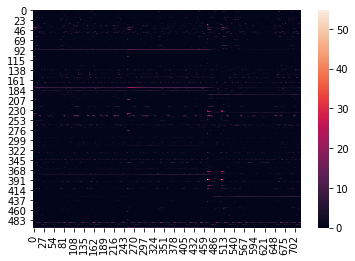

In [100]:
import seaborn as sns
sns.heatmap(hidden_list.data.numpy()[0].T)

Text(33,0.5,'neuron index')

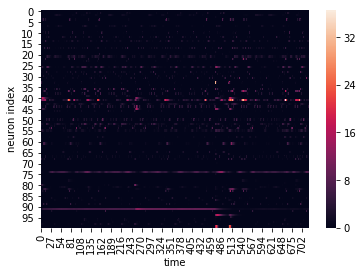

In [101]:
sns.heatmap(hidden_list.data.numpy()[0].T[:100])
plt.xlabel('time')
plt.ylabel('neuron index')
# plt.savefig('internal_dynamics2.png')

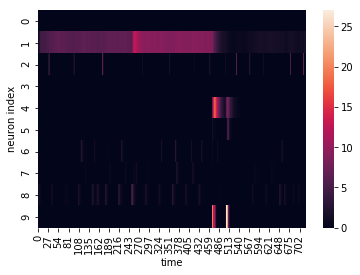

In [128]:
sns.heatmap(hidden_list.data.numpy()[0].T[90:100])
plt.xlabel('time')
plt.ylabel('neuron index')
plt.savefig('result/long_short/neurons_activation1.png')

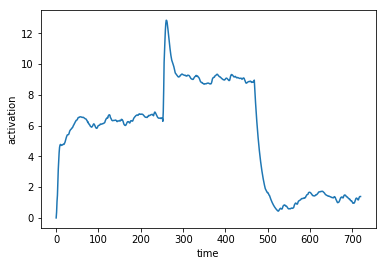

In [129]:
plt.plot(hidden_list.data.numpy()[0].T[91])
plt.xlabel('time')
plt.ylabel('activation')
plt.savefig('result/long_short/neurons_activation2.png')

Text(33,0.5,'neuron index')

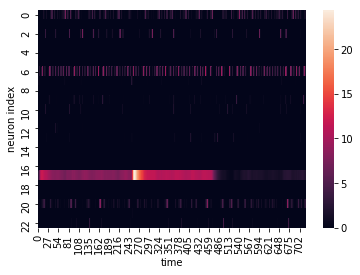

In [106]:
sns.heatmap(hidden_list.data.numpy()[0].T[161:184])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(0,0.5,'activation')

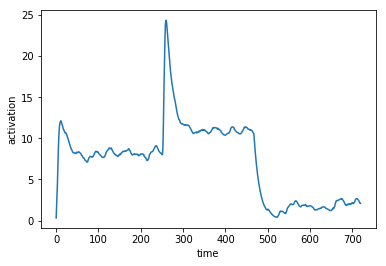

In [109]:
plt.plot(hidden_list.data.numpy()[0].T[178])
plt.xlabel('time')
plt.ylabel('activation')
# plt.savefig('activation2.png')

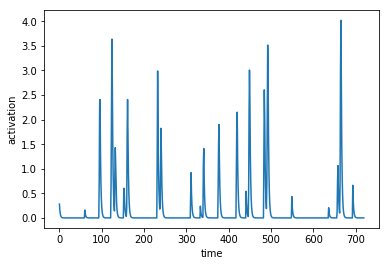

In [130]:
plt.plot(hidden_list.data.numpy()[0].T[1])
plt.xlabel('time')
plt.ylabel('activation')
plt.savefig('result/long_short/neurons_activation3.png')

Text(33,0.5,'neuron index')

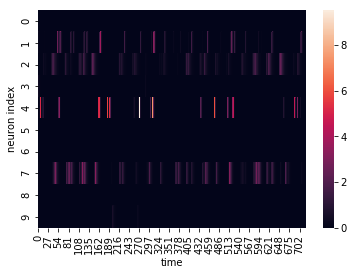

In [45]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:10])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(0.5,1,'dynamics of neurons during one episode')

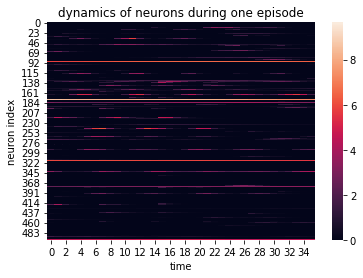

In [113]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, 36:72])
plt.xlabel('time')
plt.ylabel('neuron index')
plt.title('dynamics of neurons during one episode')

# plt.savefig('dynamics2.png')

Text(33,0.5,'neuron index')

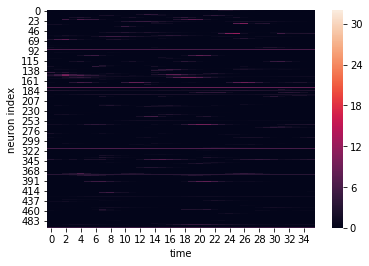

In [111]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, 72:108])
plt.xlabel('time')
plt.ylabel('neuron index')

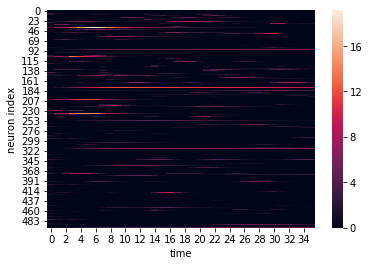

In [134]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, :36])
plt.xlabel('time')
plt.ylabel('neuron index')
plt.savefig('result/long_short/neurons_activation4.png')

Text(33,0.5,'neuron index')

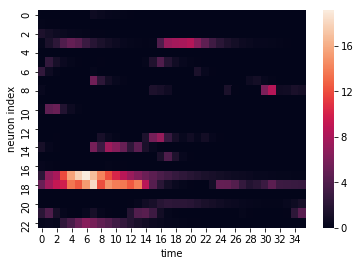

In [116]:
sns.heatmap(hidden_list.data.numpy()[0].T[23:46, :36])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(0,0.5,'activation')

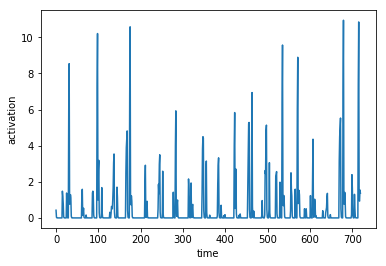

In [137]:
plt.plot(hidden_list.data.numpy()[0].T[31])
plt.xlabel('time')
plt.ylabel('activation')
# plt.savefig('activation2.png')

Text(33,0.5,'neuron index')

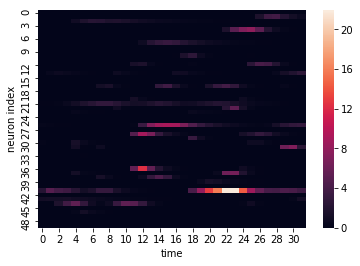

In [49]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:50, 140:172])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(33,0.5,'neuron index')

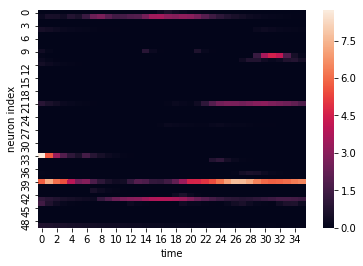

In [50]:
sns.heatmap(hidden_list.data.numpy()[0].T[-50:, 72:108])
plt.xlabel('time')
plt.ylabel('neuron index')

In [51]:
model.alpha.weight

Parameter containing:
tensor([[-0.3752],
        [-0.2108],
        [-1.4144],
        [-0.5665],
        [ 0.4496],
        [-0.7265],
        [-0.6583],
        [-1.0100],
        [ 0.7033],
        [-1.2182],
        [ 0.9119],
        [-0.0274],
        [ 0.9269],
        [-0.2729],
        [-0.2313],
        [-0.3496],
        [ 0.7867],
        [ 0.7890],
        [ 0.2660],
        [-0.1777],
        [ 0.5409],
        [-0.7274],
        [ 1.1143],
        [-0.7341],
        [-0.8240],
        [-0.8142],
        [-0.7450],
        [ 0.7731],
        [ 0.1284],
        [ 0.9490],
        [ 0.3702],
        [ 2.3212],
        [-0.0434],
        [ 0.6364],
        [ 0.6836],
        [-1.8131],
        [ 0.4769],
        [ 0.8696],
        [ 1.0871],
        [-0.4451],
        [-1.7171],
        [ 0.0326],
        [-0.6738],
        [-1.3635],
        [ 0.8498],
        [-0.9163],
        [ 0.0839],
        [-0.4080],
        [ 0.4527],
        [-1.6466],
        [ 0.4461],
        [

In [52]:
import torch.nn.functional as F
const_one = torch.Tensor([1])
alpha = F.sigmoid(model.alpha(const_one))

/Users/kohei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [24]:
alpha

tensor([0.4073, 0.4475, 0.1955, 0.3620, 0.6106, 0.3260, 0.3411, 0.2670, 0.6689,
        0.2282, 0.7134, 0.4931, 0.7164, 0.4322, 0.4424, 0.4135, 0.6871, 0.6876,
        0.5661, 0.4557, 0.6320, 0.3258, 0.7529, 0.3243, 0.3049, 0.3070, 0.3219,
        0.6842, 0.5321, 0.7209, 0.5915, 0.9106, 0.4892, 0.6539, 0.6645, 0.1403,
        0.6170, 0.7047, 0.7478, 0.3905, 0.1522, 0.5082, 0.3377, 0.2037, 0.7005,
        0.2857, 0.5210, 0.3994, 0.6113, 0.1616, 0.6097, 0.6523, 0.2967, 0.7034,
        0.8850, 0.3337, 0.2632, 0.4480, 0.3729, 0.3211, 0.6584, 0.2943, 0.5015,
        0.5451, 0.4075, 0.5949, 0.6029, 0.8099, 0.5571, 0.6967, 0.2779, 0.3375,
        0.3334, 0.4647, 0.1515, 0.7428, 0.1830, 0.6901, 0.1425, 0.1991, 0.2749,
        0.2241, 0.1870, 0.7347, 0.4804, 0.1570, 0.5197, 0.1938, 0.3487, 0.5501,
        0.4432, 0.0580, 0.7686, 0.2183, 0.1033, 0.2802, 0.3789, 0.3534, 0.2366,
        0.6135, 0.3072, 0.2520, 0.5193, 0.7596, 0.6968, 0.3540, 0.5655, 0.4511,
        0.3415, 0.7081, 0.4227, 0.5518, 

In [135]:
alpha[178]

tensor(0.0698, grad_fn=<SelectBackward>)

In [136]:
alpha.sort()

(tensor([0.0580, 0.0679, 0.0698, 0.0702, 0.0719, 0.0728, 0.0756, 0.0766, 0.0877,
         0.0907, 0.0929, 0.1032, 0.1033, 0.1054, 0.1137, 0.1154, 0.1182, 0.1230,
         0.1254, 0.1319, 0.1328, 0.1370, 0.1403, 0.1425, 0.1448, 0.1501, 0.1515,
         0.1522, 0.1565, 0.1570, 0.1604, 0.1616, 0.1685, 0.1715, 0.1735, 0.1757,
         0.1802, 0.1817, 0.1821, 0.1823, 0.1830, 0.1870, 0.1873, 0.1932, 0.1938,
         0.1955, 0.1969, 0.1988, 0.1991, 0.2027, 0.2031, 0.2037, 0.2041, 0.2048,
         0.2111, 0.2114, 0.2123, 0.2183, 0.2206, 0.2241, 0.2252, 0.2276, 0.2282,
         0.2315, 0.2366, 0.2378, 0.2395, 0.2399, 0.2402, 0.2412, 0.2475, 0.2479,
         0.2494, 0.2520, 0.2530, 0.2571, 0.2577, 0.2592, 0.2600, 0.2602, 0.2632,
         0.2632, 0.2640, 0.2641, 0.2670, 0.2698, 0.2707, 0.2712, 0.2723, 0.2723,
         0.2725, 0.2747, 0.2749, 0.2767, 0.2779, 0.2783, 0.2801, 0.2802, 0.2814,
         0.2857, 0.2859, 0.2872, 0.2889, 0.2891, 0.2923, 0.2925, 0.2935, 0.2941,
         0.2943, 0.2955, 0.2